In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/dsaa-6100-movie-review-sentiment-classification/movie_reviews/movie_reviews.csv')
print(df.head(3))

                                                text  label
0  If you havent seen this movie than you need to...      1
1  but Cinderella gets my vote not only for the w...      0
2  This movie is pretty cheesy but I do give it c...      1


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
import numpy as np
import os

def load_or_create_tokenizer(force_retrain=False):
    """
    Load existing tokenizer or create new one if it doesn't exist
    """
    tokenizer_path = 'movie_review_tokenizer/vocab.txt'
    
    if os.path.exists(tokenizer_path) and not force_retrain:
        print("Loading existing tokenizer...")
        return BertWordPieceTokenizer.from_file(tokenizer_path)
    
    print("Creating new tokenizer...")
    return train_new_tokenizer()

def train_new_tokenizer():
    """
    Train a new tokenizer
    """
    # Save training texts to file
    print("Preparing training data...")
    with open('train.txt', 'w', encoding='utf-8') as f:
        for text in train_texts:
            f.write(str(text) + '\n')

    # Initialize and train tokenizer
    print("Training tokenizer...")
    tokenizer = BertWordPieceTokenizer(
        clean_text=True,
        handle_chinese_chars=True,
        strip_accents=True,
        lowercase=True,
    )

    # Train the tokenizer
    tokenizer.train(
        files=['train.txt'],
        vocab_size=10000,
        min_frequency=2,
        special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'],
        limit_alphabet=1000,
        wordpieces_prefix="##"
    )

    # Save the tokenizer
    print("Saving tokenizer...")
    os.makedirs('movie_review_tokenizer', exist_ok=True)
    tokenizer.save_model('movie_review_tokenizer')
    
    return tokenizer

def encode_texts(texts, tokenizer, max_length=128):
    """
    Encode texts using the tokenizer
    """
    encodings = []
    attention_masks = []
    
    for text in tqdm(texts, desc="Encoding texts"):
        encoded = tokenizer.encode(text)
        
        input_ids = encoded.ids
        attention_mask = encoded.attention_mask
        
        if len(input_ids) > max_length:
            input_ids = input_ids[:max_length]
            attention_mask = attention_mask[:max_length]
        else:
            padding_length = max_length - len(input_ids)
            input_ids = input_ids + [tokenizer.token_to_id('[PAD]')] * padding_length
            attention_mask = attention_mask + [0] * padding_length
            
        encodings.append(input_ids)
        attention_masks.append(attention_mask)
    
    return np.array(encodings), np.array(attention_masks)

def load_or_create_encodings(tokenizer, force_recompute=False):
    """
    Load existing encodings or create new ones if they don't exist
    """
    encoded_files = [
        'encoded_data/train_encodings.npy',
        'encoded_data/train_masks.npy',
        'encoded_data/eval_encodings.npy',
        'encoded_data/eval_masks.npy'
    ]
    
    # Check if all files exist
    files_exist = all(os.path.exists(f) for f in encoded_files)
    
    if files_exist and not force_recompute:
        print("Loading existing encodings...")
        return (
            np.load('encoded_data/train_encodings.npy'),
            np.load('encoded_data/train_masks.npy'),
            np.load('encoded_data/eval_encodings.npy'),
            np.load('encoded_data/eval_masks.npy')
        )
    
    print("Creating new encodings...")
    return create_new_encodings(tokenizer)

def create_new_encodings(tokenizer):
    """
    Create and save new encodings
    """
    print("Encoding training and evaluation sets...")
    train_encodings, train_masks = encode_texts(train_texts, tokenizer)
    eval_encodings, eval_masks = encode_texts(eval_texts, tokenizer)
    
    # Save encodings
    print("Saving encodings...")
    os.makedirs('encoded_data', exist_ok=True)
    np.save('encoded_data/train_encodings.npy', train_encodings)
    np.save('encoded_data/train_masks.npy', train_masks)
    np.save('encoded_data/eval_encodings.npy', eval_encodings)
    np.save('encoded_data/eval_masks.npy', eval_masks)
    
    return train_encodings, train_masks, eval_encodings, eval_masks

def test_tokenizer(tokenizer):
    """
    Test the tokenizer
    """
    print("\nTesting tokenizer:")
    test_text = "This movie was absolutely amazing!"
    
    encoded = tokenizer.encode(test_text)
    
    print(f"Original text: {test_text}")
    print(f"Tokens: {encoded.tokens}")
    print(f"IDs: {encoded.ids}")
    print(f"Attention mask: {encoded.attention_mask}")
    
    print(f"\nVocabulary size: {tokenizer.get_vocab_size()}")
    
    vocab = tokenizer.get_vocab()
    print("\nSample vocabulary entries:")
    sample_tokens = list(vocab.items())[:10]
    for token, id in sample_tokens:
        print(f"{token}: {id}")

def check_coverage(tokenizer, train_encodings):
    """
    Check vocabulary coverage
    """
    unk_token_id = tokenizer.token_to_id('[UNK]')
    train_unks = (train_encodings == unk_token_id).sum()
    total_train_tokens = train_encodings.size
    
    print("\nVocabulary Coverage:")
    print(f"Unknown tokens in training: {train_unks}/{total_train_tokens}")
    print(f"Coverage: {(1 - train_unks/total_train_tokens)*100:.2f}%")

# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    df = pd.read_csv('/kaggle/input/dsaa-6100-movie-review-sentiment-classification/movie_reviews/movie_reviews.csv')
    
    # Split data
    train_texts, eval_texts, train_labels, eval_labels = train_test_split(
        df['text'].tolist(),
        df['label'].values,
        test_size=0.2, 
        random_state=42
    )
    
    # Get tokenizer (will load if exists, create if doesn't)
    tokenizer = load_or_create_tokenizer(force_retrain=False)
    
    # Get encodings (will load if exists, create if doesn't)
    train_encodings, train_masks, eval_encodings, eval_masks = load_or_create_encodings(
        tokenizer, 
        force_recompute=False
    )
    
    # Test tokenizer
    test_tokenizer(tokenizer)
    
    # Print shapes
    print("\nFinal shapes:")
    print(f"Train encodings: {train_encodings.shape}")
    print(f"Train masks: {train_masks.shape}")
    print(f"Eval encodings: {eval_encodings.shape}")
    print(f"Eval masks: {eval_masks.shape}")
    
    # Check coverage
    check_coverage(tokenizer, train_encodings)

Loading data...
Loading existing tokenizer...
Loading existing encodings...

Testing tokenizer:
Original text: This movie was absolutely amazing!
Tokens: ['[CLS]', 'this', 'movie', 'was', 'absolutely', 'amazing', '[UNK]', '[SEP]']
IDs: [2, 149, 184, 164, 1417, 1581, 1, 3]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1]

Vocabulary size: 10000

Sample vocabulary entries:
havent: 2096
##ails: 4252
disney: 2610
clich: 1867
cats: 6324
hardy: 6484
pir: 5549
accepted: 5919
godz: 9911
concert: 5777

Final shapes:
Train encodings: (32000, 128)
Train masks: (32000, 128)
Eval encodings: (8000, 128)
Eval masks: (8000, 128)

Vocabulary Coverage:
Unknown tokens in training: 0/4096000
Coverage: 100.00%


In [24]:
import tensorflow as tf
from tensorflow import keras
from keras import Layer, activations
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Positional_Embedding(Layer):
    def __init__(self, vocab_size, max_length, embed_dim, activation=None, **kwargs):
        super(Positional_Embedding, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embed_dim = embed_dim
        self.activation = activations.get(activation)
        
        self.token_embedding = keras.layers.Embedding(
            vocab_size, embed_dim,
            embeddings_initializer=keras.initializers.he_uniform(),
            name="token_embedding"
        )
        
        self.position_embedding = keras.layers.Embedding(
            max_length, embed_dim,
            embeddings_initializer=keras.initializers.he_uniform(),
            name="position_embedding"
        )

    def call(self, inputs, training=None):
        seq_length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=seq_length, delta=1)
        token_embeddings = self.token_embedding(inputs)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings
        
        if self.activation is not None:
            embeddings = self.activation(embeddings)
        return embeddings
        
@register_keras_serializable()
class Attention_Head(Layer):
    def __init__(self, head_dim, **kwargs):
        super(Attention_Head, self).__init__(**kwargs)
        self.head_dim = head_dim

    def build(self, input_shape):
        wt_shape = (input_shape[-1], self.head_dim)
        self.query_attention_weights = self.add_weight(
            shape=wt_shape,
            initializer=keras.initializers.he_uniform(),
            regularizer=keras.regularizers.l2(),
            trainable=True,
            name="Q_weights"
        )
        self.key_attention_weights = self.add_weight(
            shape=wt_shape,
            initializer=keras.initializers.he_uniform(),
            regularizer=keras.regularizers.l2(),
            trainable=True,
            name="K_weights"
        )
        self.value_attention_weights = self.add_weight(
            shape=wt_shape,
            initializer=keras.initializers.he_uniform(),
            regularizer=keras.regularizers.l2(),
            trainable=True,
            name="V_weights"
        )
        super().build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.query_attention_weights)
        k = tf.matmul(inputs, self.key_attention_weights)
        v = tf.matmul(inputs, self.value_attention_weights)

        qk = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(float(self.head_dim))
        soft_qk = keras.activations.softmax(qk)
        output = tf.matmul(soft_qk, v)
        return output
        
@register_keras_serializable()
class Residual_Norm_Layer(Layer):
    def __init__(self, **kwargs):
        super(Residual_Norm_Layer, self).__init__(**kwargs)
        self.normlayer = keras.layers.LayerNormalization()
    
    def call(self, inputs):
        attention_output, original_input = inputs
        added = attention_output + original_input
        normalized = self.normlayer(added)
        return normalized

In [25]:
@register_keras_serializable()
class Transformer_Encoder(keras.Model):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads=8, num_layers=6, 
                 ff_dim=None, dropout_rate=0.1, **kwargs):
        super(Transformer_Encoder, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        
        if ff_dim is None:
            ff_dim = 4 * embed_dim
            
        self.embedding = Positional_Embedding(
            vocab_size=vocab_size,
            max_length=max_length,
            embed_dim=embed_dim
        )
        
        self.attention_heads = [[Attention_Head(head_dim=self.head_dim) 
                               for _ in range(num_heads)] 
                              for _ in range(num_layers)]
        
        self.attention_norms = [Residual_Norm_Layer() 
                              for _ in range(num_layers)]
        
        self.ff_layers = [keras.Sequential([
            keras.layers.Dense(ff_dim, activation='relu'),
            keras.layers.Dropout(dropout_rate),
            keras.layers.Dense(embed_dim)
        ]) for _ in range(num_layers)]
        
        self.ff_norms = [Residual_Norm_Layer() 
                        for _ in range(num_layers)]
            
    def call(self, inputs, training=None):
        x = self.embedding(inputs, training=training)
        
        for i in range(len(self.attention_heads)):
            attention_outputs = []
            for head in self.attention_heads[i]:
                attention_outputs.append(head(x))
            
            attention_outputs = tf.stack(attention_outputs, axis=-1)
            attention_output = tf.reshape(attention_outputs, 
                                        [-1, tf.shape(x)[1], self.embed_dim])
            
            x = self.attention_norms[i]([attention_output, x])
            ff_output = self.ff_layers[i](x, training=training)
            x = self.ff_norms[i]([ff_output, x])
            
        return x

@register_keras_serializable()
class Transformer_Classifier(keras.Model):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads=8, num_layers=6,
                 ff_dim=None, dropout_rate=0.1, **kwargs):
        super(Transformer_Classifier, self).__init__(**kwargs)
        
        self.encoder = Transformer_Encoder(
            vocab_size=vocab_size,
            max_length=max_length,
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            ff_dim=ff_dim,
            dropout_rate=dropout_rate
        )
        
        self.classifier = keras.Sequential([
            keras.layers.GlobalAveragePooling1D(),
            
            keras.layers.Dense(256, activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(dropout_rate),
            
            keras.layers.Dense(128, activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(dropout_rate),
            
            keras.layers.Dense(64, activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(dropout_rate),
            
            keras.layers.Dense(1, activation='sigmoid',
                kernel_initializer='he_normal')
        ])
        
    def call(self, inputs, training=None):
        encoder_output = self.encoder(inputs, training=training)
        return self.classifier(encoder_output, training=training)

In [74]:
def create_tf_dataset(X, y, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def predict_sentiment(text, tokenizer, model):
    encoded = tokenizer.encode(text)
    input_ids = encoded.ids
    
    if len(input_ids) < 128:
        input_ids = input_ids + [0] * (128 - len(input_ids))
    else:
        input_ids = input_ids[:128]
    
    input_tensor = tf.convert_to_tensor([input_ids])
    prediction = model.predict(input_tensor)[0][0]
    print('prediction', prediction)
    return {
        'text': text,
        'sentiment': 'Positive' if prediction > 0.5 else 'Negative',
        'confidence': float(prediction if prediction > 0.5 else 1 - prediction)
    }

In [27]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices:', strategy.num_replicas_in_sync)
    
batch_size = 512 * strategy.num_replicas_in_sync
    
train_dataset = create_tf_dataset(train_encodings, train_labels, batch_size=batch_size)
val_dataset = create_tf_dataset(eval_encodings, eval_labels, batch_size=batch_size)
print('done')

Number of devices: 2
done


In [28]:
def train_sentiment_classifier(
    train_dataset,
    val_dataset,
    tokenizer,
    vocab_size=10000,
    max_length=128,
    embed_dim=256,
    num_heads=8,
    num_layers=4,
    dropout_rate=0.1,
    batch_size=32,
    epochs=10,
    learning_rate=1e-4,
    resume_training=False,
    early_stopping_patience=3,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5,
    min_learning_rate=1e-6,
    checkpoint_path="/kaggle/working/sentiment_model_checkpoint.keras",
    plot_training=True,
    run_test_predictions=True,
    test_texts=None
):
    
   
    with strategy.scope():
        if resume_training and os.path.exists(checkpoint_path):
            print("Loading existing model...")
            model = tf.keras.models.load_model(checkpoint_path)
            current_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
            print(f"Current learning rate: {current_lr}")
            
            if current_lr != learning_rate:
                tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
                print(f"Updated learning rate to: {learning_rate}")
        else:
            print("Creating new model...")
            model = Transformer_Classifier(
                vocab_size=vocab_size,
                max_length=max_length,
                embed_dim=embed_dim,
                num_heads=num_heads,
                num_layers=num_layers,
                dropout_rate=dropout_rate
            )
            
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=0
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=reduce_lr_factor,
            patience=reduce_lr_patience,
            min_lr=min_learning_rate,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            'training_log.csv',
            append=resume_training
        )
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    if plot_training:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(history.history['loss'], label='train')
        ax1.plot(history.history['val_loss'], label='validation')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(history.history['accuracy'], label='train')
        ax2.plot(history.history['val_accuracy'], label='validation')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if run_test_predictions:
        if test_texts is None:
            test_texts = [
                "This movie was absolutely amazing!",
                "I really hated this film, it was terrible.",
                "An okay movie, nothing special."
            ]
        
        print("\nTest Predictions:")
        for text in test_texts:
            result = predict_sentiment(text, tokenizer, model)
            print(f"\nText: {result['text']}")
            print(f"Sentiment: {result['sentiment']}")
            print(f"Confidence: {result['confidence']:.2%}")
    
    return model, history



Creating new model...
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5065 - auc: 0.5072 - loss: 61.9898 - val_accuracy: 0.5030 - val_auc: 0.6057 - val_loss: 60.1414 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5094 - auc: 0.5139 - loss: 59.4425 - val_accuracy: 0.5058 - val_auc: 0.6606 - val_loss: 57.4438 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5365 - auc: 0.5520 - loss: 56.8755 - val_accuracy: 0.4940 - val_auc: 0.7332 - val_loss: 54.8216 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5586 - auc: 0.5872 - loss: 54.3526 - val_accuracy: 0.5010 - val_auc: 0.8077 - val_loss: 52.4758 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6237 - auc: 0.6716 - loss: 51.8344 - val_accuracy: 0.5065 - val_auc: 0.8555 - val_loss: 50.4179 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━

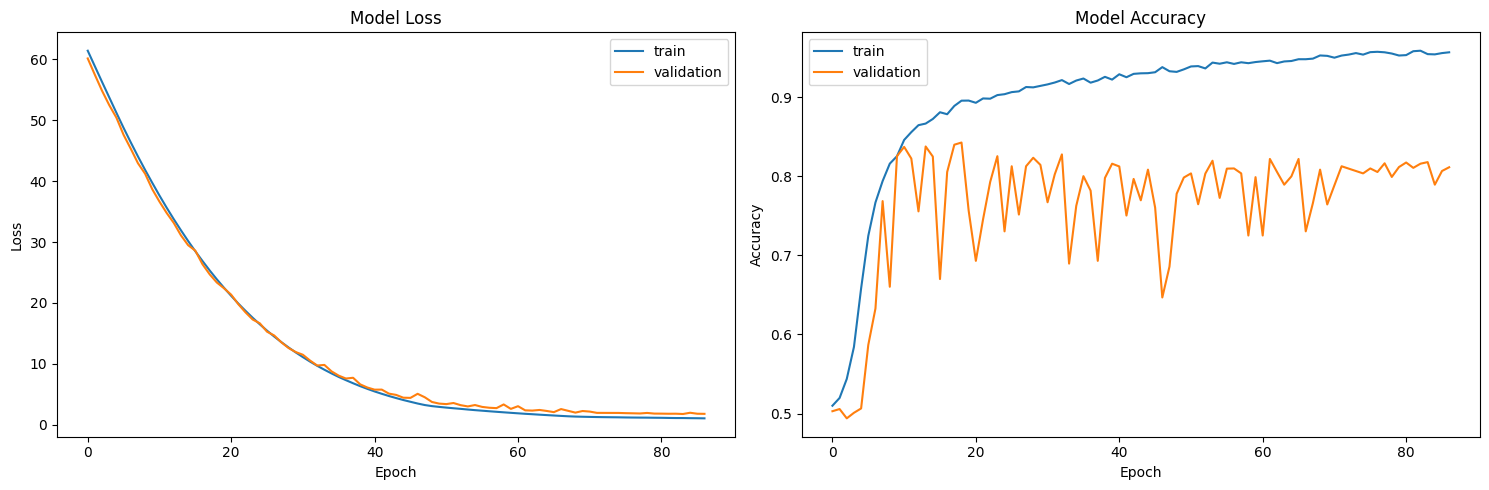


Test Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Text: This movie was absolutely amazing!
Sentiment: Negative
Confidence: 67.66%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Text: I really hated this film, it was terrible.
Sentiment: Negative
Confidence: 99.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Text: An okay movie, nothing special.
Sentiment: Negative
Confidence: 99.26%


In [33]:
model, history =  train_sentiment_classifier(
    train_dataset,
    val_dataset,
    tokenizer,
    
    vocab_size=10000,
    max_length=128,
    embed_dim=256,
    num_heads=8,
    num_layers=4,
    dropout_rate=0.4,
    epochs=200,
    learning_rate=1e-4,
    resume_training=False,
    early_stopping_patience=3,
    reduce_lr_patience=2,
    reduce_lr_factor=0.5,
    min_learning_rate=1e-6,
    checkpoint_path="/kaggle/working/sentiment_model_checkpoint.keras",
    plot_training=True,
    run_test_predictions=True,
    test_texts=None
)

In [35]:
model.save('dfdf.keras')

In [88]:
text = df[df['label']==0].iloc[10250]['text']
text

'What a travesty of movie ratings injustice  a 21 on the IMDb scale as I write this Folks this is a lot closer to a 30 Ill even go out on a limb and say 40 where Ive put it Come on  how can you have a movie about a net of static electricity surrounding the earth and alien amorphic cell structures and not give it at least a 40 for creativity Then youve got all that great dialog like  Dave look at the composition of this mud You know I dont think they ever got back to that mud No matter this is the kind of flick that Z movie diehards live for and I can now rest easy Actually I saw this quite a few years ago without the proper appreciation for it along with Corman titles like Attack of the Giant Leeches  and The Wasp Woman I dont know what the fascination might be but to quote a character from the film  Whatever it is it works fast Back to that alien amorphic cell structure  I liked the idea of a third element competing against your standard red and white blood cells When astronaut John C

In [89]:
predict_sentiment(str(text), tokenizer, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
prediction 0.010792807


{'text': 'What a travesty of movie ratings injustice  a 21 on the IMDb scale as I write this Folks this is a lot closer to a 30 Ill even go out on a limb and say 40 where Ive put it Come on  how can you have a movie about a net of static electricity surrounding the earth and alien amorphic cell structures and not give it at least a 40 for creativity Then youve got all that great dialog like  Dave look at the composition of this mud You know I dont think they ever got back to that mud No matter this is the kind of flick that Z movie diehards live for and I can now rest easy Actually I saw this quite a few years ago without the proper appreciation for it along with Corman titles like Attack of the Giant Leeches  and The Wasp Woman I dont know what the fascination might be but to quote a character from the film  Whatever it is it works fast Back to that alien amorphic cell structure  I liked the idea of a third element competing against your standard red and white blood cells When astrona

In [90]:
sub_df = pd.read_csv('/kaggle/input/dsaa-6100-movie-review-sentiment-classification/test_data.csv')
sub_df.head(5)

,Id,text
0,0,What can possibly said about this movie other ...
1,1,I dont care how many bad reviews purple rain g...
2,2,Ken Russell directed this weird Not very ero...
3,3,This is a great movie from the lost age of rea...
4,4,I have a problem with the movie snobs who cons...


In [150]:


def predict_sentiment_two(text, tokenizer, model, threshold):
    encoded = tokenizer.encode(text)
    input_ids = encoded.ids
    
    if len(input_ids) < 128:
        input_ids = input_ids + [0] * (128 - len(input_ids))
    else:
        input_ids = input_ids[:128]
    
    input_tensor = tf.convert_to_tensor([input_ids])
    prediction = model.predict(input_tensor, verbose=0)[0][0]
    # print('prediction', prediction)
    # if prediction >= threshold:
    #     final = 1
    # else:
    #     final = 0
    return prediction

In [151]:
from tqdm.notebook import tqdm  # for Jupyter notebook

# Create a tqdm wrapper for the mapping operation
tqdm.pandas()  # This enables the progress_map method

# Now use progress_map instead of map
sub_df['Predictions'] = sub_df['text'].progress_map(lambda x: predict_sentiment_two(x, tokenizer, model, threshold=0.5))
sub_df.head(5)

  0%|          | 0/10000 [00:00<?, ?it/s]

,Id,text,Predictions
0,0,What can possibly said about this movie other ...,0.012146
1,1,I dont care how many bad reviews purple rain g...,0.999982
2,2,Ken Russell directed this weird Not very ero...,0.000048
3,3,This is a great movie from the lost age of rea...,0.999913
4,4,I have a problem with the movie snobs who cons...,0.999528


In [152]:
sub_df.to_csv("pred_df.csv")

In [161]:
def thres_predict(x, thres):
    if x < thres:
        return 0
    else:
        return 1
sub_df['Category'] = sub_df['Predictions'].map(lambda x: thres_predict(x, 0.08))
sub_df.head(5)

,Id,text,Predictions,Category
0,0,What can possibly said about this movie other ...,0.012146,0
1,1,I dont care how many bad reviews purple rain g...,0.999982,1
2,2,Ken Russell directed this weird Not very ero...,0.000048,0
3,3,This is a great movie from the lost age of rea...,0.999913,1
4,4,I have a problem with the movie snobs who cons...,0.999528,1


In [162]:
final_df = sub_df.drop(columns=['text', 'Predictions'])
final_df.head()  

,Id,Category
0,0,0
1,1,1
2,2,0
3,3,1
4,4,1


In [163]:
final_df.to_csv("sub_08.csv", index=False)